# Classification. Linear models and KNN

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [4]:
from sklearn.exceptions import NotFittedError

In [5]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.loss = list()
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        # <your code>
        return 1 / (1 + np.exp(-X @ weights))
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        # <your code>
        loss = np.log(1 + np.exp(-(weights @ x.T) * y)).mean() + (np.linalg.norm(weights) ** 2) / (2 * self.C)
        return loss
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        
        for i in range(self.max_iter):
            r1 = (1 - 1 / (1 + np.exp(-(self.weights_ @ X_ext.T) * y)))
            delta = -(X_ext.T @ (y * r1)) / len(y) + self.weights_ / self.C
            self.weights_ -= self.eta * delta
            self.loss.append(self.get_loss(X_ext, self.weights_, y))
            if np.linalg.norm(delta) < self.tol:
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        return np.where(self.predict_proba(X) >= 0.5, 1, -1)

In [6]:
from sklearn import datasets
from sklearn import metrics

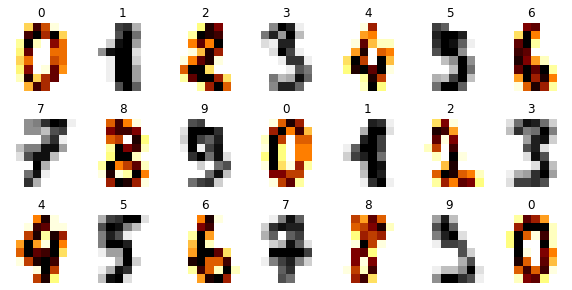

In [7]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [8]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [9]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)    
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [10]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [11]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [12]:
lr_clf.fit(X_train, y_train)

In [13]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [14]:
model = CustomLogisticRegression()

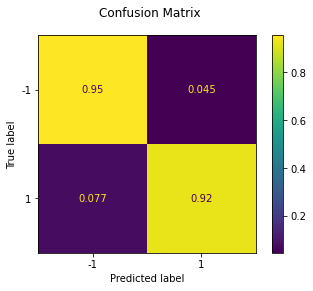

In [15]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [16]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [17]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

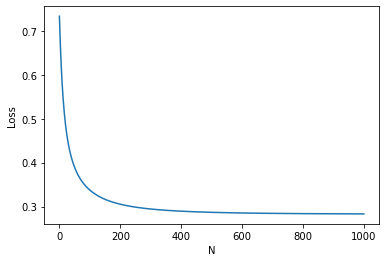

In [18]:
plt.plot(model.loss)
plt.xlabel('N')
plt.ylabel('Loss')
plt.show()

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

eta = 0.0001


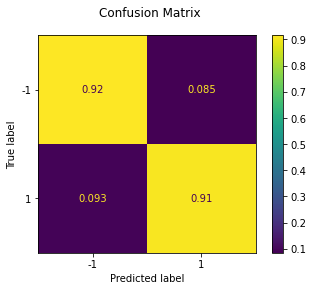

0.8844815588030619 0.9111111111111111


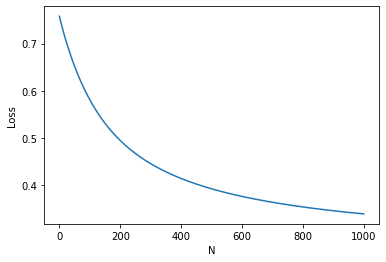


eta = 0.001


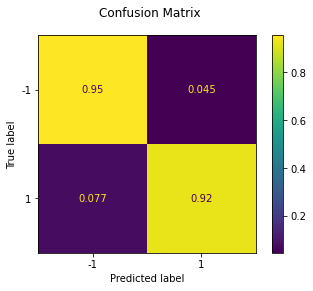

0.9109255393180237 0.9388888888888889


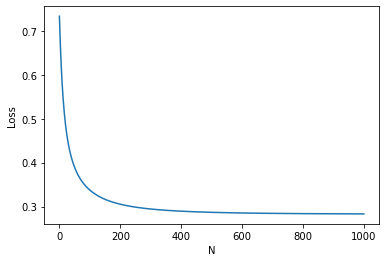


eta = 0.01


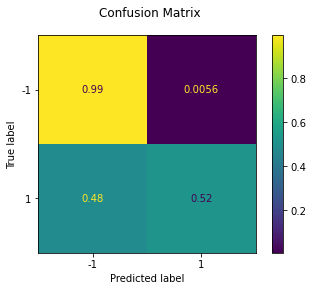

0.7731384829505915 0.7527777777777778


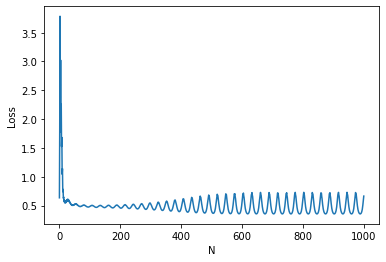

In [19]:
for i in [0.0001, 0.001, 0.01]:
    m = CustomLogisticRegression(eta=i)
    print("eta =", i)
    train_acc_m, test_acc_m = fit_evaluate(m, X_train, y_train, X_test, y_test)
    print(train_acc_m, test_acc_m)
    plt.plot(m.loss)
    plt.xlabel('N')
    plt.ylabel('Loss')
    plt.show()
    print()

При большом шаге модель перепрыгивает через минимум, а при маленьком - сходится очень медленно

**(0.5 points)** Try different regularization parameter values and compare the model quality.

C = 0.2


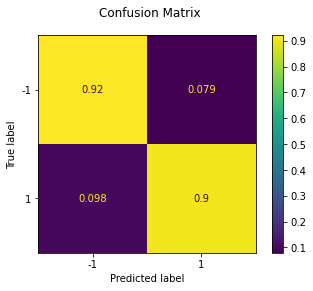

0.8970076548364648 0.9111111111111111


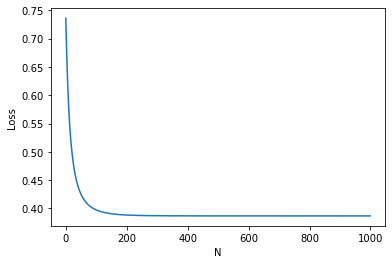


C = 1.0


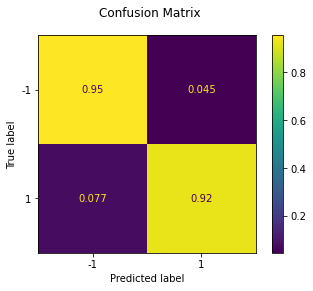

0.9109255393180237 0.9388888888888889


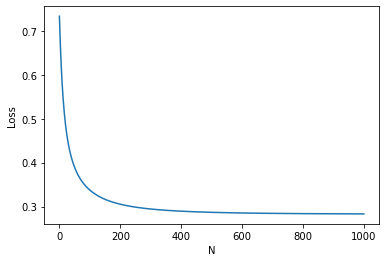


C = 5.0


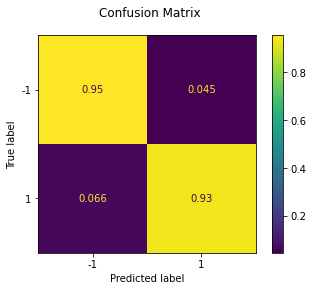

0.9151009046624913 0.9444444444444444


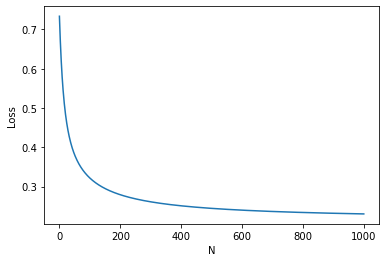

In [20]:
for i in [0.2, 1.0, 5.0]:
    m = CustomLogisticRegression(C=i)
    print("C =", i)
    train_acc_m, test_acc_m = fit_evaluate(m, X_train, y_train, X_test, y_test)
    print(train_acc_m, test_acc_m)
    plt.plot(m.loss)
    plt.xlabel('N')
    plt.ylabel('Loss')
    plt.show()
    print()

При неправильно подобранном параметре регуляризации можно увидеть переобучение и недообучение модели

**(0.5 points)** Compare zero initialization and random initialization. 

zero_init=False


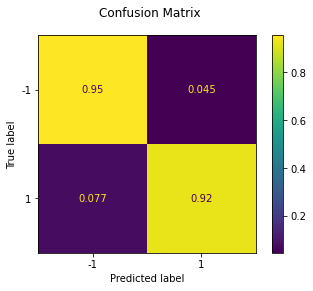

0.9109255393180237 0.9388888888888889


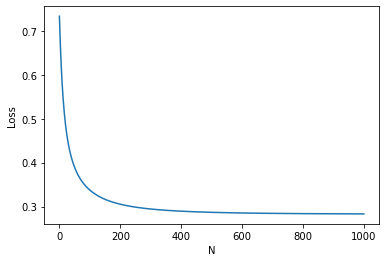


zero_init=True


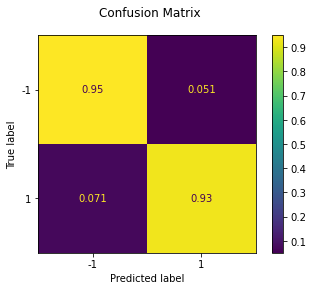

0.9116214335421016 0.9388888888888889


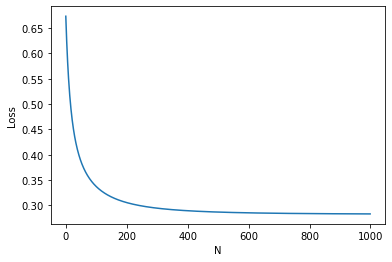

In [21]:
print("zero_init=False")
m = CustomLogisticRegression(zero_init=False)
train_acc_m, test_acc_m = fit_evaluate(m, X_train, y_train, X_test, y_test)
print(train_acc_m, test_acc_m)
plt.plot(model.loss)
plt.xlabel('N')
plt.ylabel('Loss')
plt.show()
print()

m = CustomLogisticRegression(zero_init=True)
print("zero_init=True")
train_acc_m, test_acc_m = fit_evaluate(m, X_train, y_train, X_test, y_test)
print(train_acc_m, test_acc_m)
plt.plot(m.loss)
plt.xlabel('N')
plt.ylabel('Loss')
plt.show()
print()

видим на случайной инициализации чуть лучше результаты модели

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [22]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        # <your code>
        return np.sqrt(((np.expand_dims(X, 0) - np.expand_dims(Y, 1))**2).sum(axis=-1)).T
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        # <your code>
        w = []
        for i in self.classes_:
            s = 0
            for j in range(len(y)):
                if y[j] == i:
                    s += weights[j]
            w.append(s)
        return w
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            n_p = P.argsort(axis=1)[:, :self.n_neighbors]
            s_d = P[np.arange(P.shape[0])[:,None], n_p]
            labels = self.y[n_p]
            
            weights_ = np.ones(labels.shape)
            if self.weights == 'distance':
                weights_ = 1 / np.maximum(s_d, self.eps)
            count_labels = np.array([self.get_class_weights(labels[i], weights_[i]) for i in range(len(P))])
            weights_of_points = count_labels / np.expand_dims(count_labels.sum(axis=1), 1)
            return np.array(weights_of_points)
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        return self.predict_proba(X).argmax(axis=1)

In [23]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [24]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [25]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

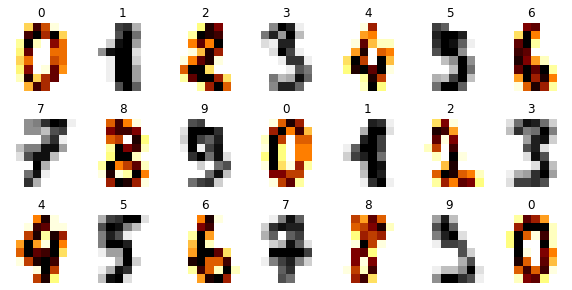

In [26]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [27]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [28]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

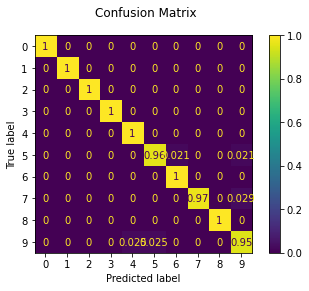

In [29]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [30]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

Видим модель чуть путает:  
5 и 6,  
5 и 9,  
7 и 9,  
9 и 4.  
Это логично, так как цифры очень похожи и отличаются лишь чертой.

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

n_neighbors = 1


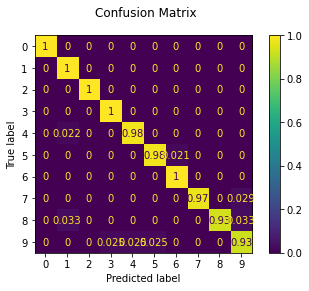

n_neighbors = 5


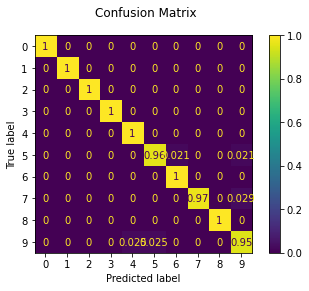

n_neighbors = 10


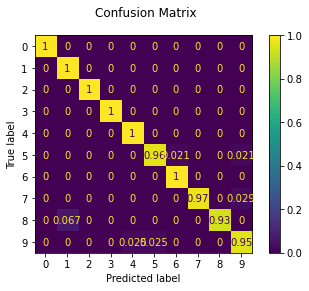

In [31]:
for i in [1, 5, 10]:
    m = CustomKNeighborsClassifier(n_neighbors=i, weights='distance')
    m.fit(X_train, y_train)
    print("n_neighbors =", i)
    fit_evaluate(m, X_train, y_train, X_test, y_test)

Видим разные результаты моделей, на некоторых хуже, на некоторых хуже в зависимости от n_neighbors

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

weights='uniform'


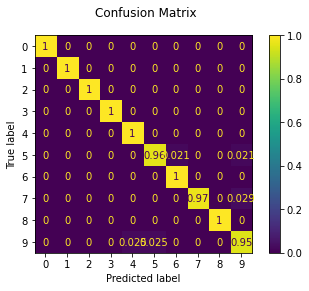

weights='distance'


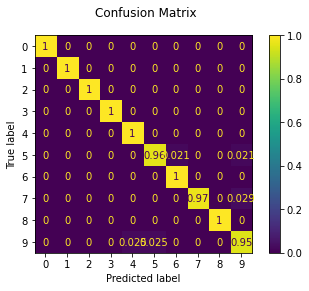

(1.0, 0.9861111111111112)

In [32]:
m = CustomKNeighborsClassifier(n_neighbors=5, weights='uniform')
m.fit(X_train, y_train)
print("weights='uniform'")
fit_evaluate(m, X_train, y_train, X_test, y_test)

m = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
m.fit(X_train, y_train)
print("weights='distance'")
fit_evaluate(m, X_train, y_train, X_test, y_test)

разница в данном слечае нет, но weights='distance' может приводить к переобучению

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

можно попробовать использовать манхэттенское расстояние.

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

Косинусное расстояние часто используется для измерения схожести между текстами.

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [33]:
data = pd.read_csv(os.path.join('train.csv')).set_index('PassengerId')

In [34]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Survived  100000 non-null  int64  
 1   Pclass    100000 non-null  int64  
 2   Name      100000 non-null  object 
 3   Sex       100000 non-null  object 
 4   Age       96708 non-null   float64
 5   SibSp     100000 non-null  int64  
 6   Parch     100000 non-null  int64  
 7   Ticket    95377 non-null   object 
 8   Fare      99866 non-null   float64
 9   Cabin     32134 non-null   object 
 10  Embarked  99750 non-null   object 
dtypes: float64(2), int64(4), object(5)
memory usage: 9.2+ MB


Заполним сразу пропущееные значения

In [36]:
age_median = data['Age'].median()
data['Age'] = data['Age'].fillna(age_median)
data['Ticket'] = data['Ticket'].fillna('without')
fare_mean = np.mean(data['Fare'])
data['Fare'].fillna(fare_mean, inplace=True)
data['Cabin'] = data['Cabin'].fillna('N')
data['Cabin_type'] = data['Cabin'].str.extract('([A-Z])')
data['Embarked'] = data['Embarked'].fillna('N')

### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

количество мужчин и женщин

In [37]:
data['Sex'].value_counts()

male      56114
female    43886
Name: Sex, dtype: int64

количество умерших (0) и выживших (1)

In [38]:
data['Survived'].value_counts()

0    57226
1    42774
Name: Survived, dtype: int64

выживаемость женщин

In [39]:
data[data['Sex']=='female']['Survived'].value_counts()

1    31226
0    12660
Name: Survived, dtype: int64

выживаемость мужчин

In [40]:
data[data['Sex']=='male']['Survived'].value_counts()

0    44566
1    11548
Name: Survived, dtype: int64

Женщины выживали чаще мужчин.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

возраста всех пассажиров

count    100000.000000
mean         38.376690
std          18.009956
min           0.080000
25%          25.000000
50%          39.000000
75%          53.000000
max          87.000000
Name: Age, dtype: float64

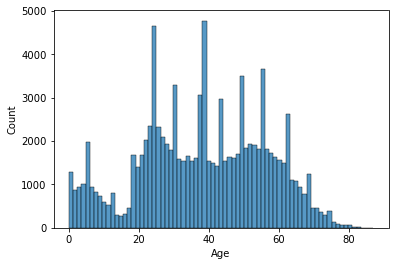

In [41]:
sns.histplot(data['Age'])
data['Age'].describe()

возраста умерших пассажиров

count    57226.000000
mean        36.786212
std         17.510114
min          0.080000
25%         24.000000
50%         37.000000
75%         51.000000
max         83.000000
Name: Age, dtype: float64

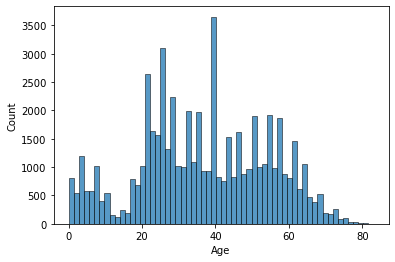

In [42]:
sns.histplot(data[data['Survived']==0]['Age'])
data[data['Survived']==0]['Age'].describe()

возраста выживших пассажиров

count    42774.000000
mean        40.504542
std         18.444704
min          0.080000
25%         27.000000
50%         42.000000
75%         55.000000
max         87.000000
Name: Age, dtype: float64

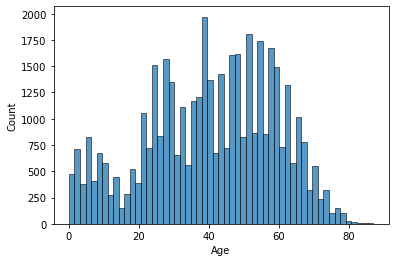

In [43]:
sns.histplot(data[data['Survived']==1]['Age'])
data[data['Survived']==1]['Age'].describe()

распределение выживших и умерших пассажиров по возрасту особо не отличается

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

In [44]:
data.groupby('Pclass')['Survived'].mean()

Pclass
1    0.579779
2    0.525018
3    0.247305
Name: Survived, dtype: float64

<AxesSubplot:xlabel='Pclass', ylabel='count'>

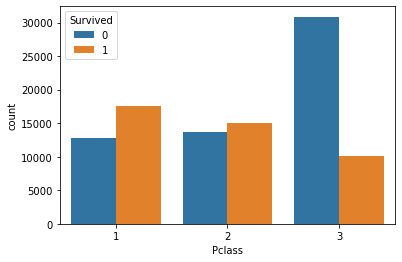

In [45]:
sns.countplot(x='Pclass', hue='Survived', data=data) 

Больше всего пассажиров выжило из первого класса, а погибло больше всего из тертьего

In [46]:
data.groupby('Embarked')['Survived'].mean()

Embarked
C    0.751296
N    0.488000
Q    0.596976
S    0.315294
Name: Survived, dtype: float64

<AxesSubplot:xlabel='Embarked', ylabel='count'>

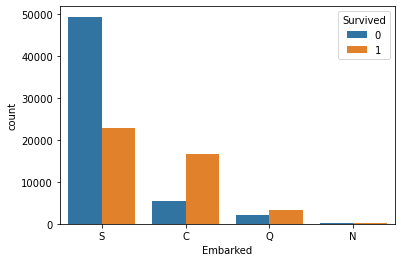

In [47]:
sns.countplot(x='Embarked', hue='Survived', data=data) 

Определенной зависимости выживаемости из-за места посадки нет, но из тех, кто садился в Southampton, большинство погибло. Видимо в Southampton большинство покупало третий класс билетов.

<AxesSubplot:xlabel='Embarked', ylabel='count'>

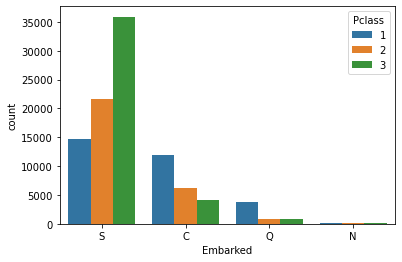

In [48]:
sns.countplot(x='Embarked', hue='Pclass', data=data) 

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [49]:
data.isna().mean()

Survived      0.0
Pclass        0.0
Name          0.0
Sex           0.0
Age           0.0
SibSp         0.0
Parch         0.0
Ticket        0.0
Fare          0.0
Cabin         0.0
Embarked      0.0
Cabin_type    0.0
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

Я убрал пропущенные значения сразу после загрузки данных, перед исследованием.  
Например: неуказанный возраст заменил на медианное значение.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [88]:
from sklearn.linear_model import LogisticRegression

In [89]:
train_data = data.copy()

In [90]:
train_data['Sex_m'] = train_data['Sex'].apply(lambda x: 1 if x == 'male' else 0)

train_data['E_S'] = train_data['Embarked'].apply(lambda x: 1 if x == 'S' else 0)
train_data['E_C'] = train_data['Embarked'].apply(lambda x: 1 if x == 'C' else 0)
train_data['E_Q'] = train_data['Embarked'].apply(lambda x: 1 if x == 'Q' else 0)

train_data['C_C'] = train_data['Cabin_type'].apply(lambda x: 1 if x == 'C' else 0)
train_data['C_B'] = train_data['Cabin_type'].apply(lambda x: 1 if x == 'B' else 0)
train_data['C_A'] = train_data['Cabin_type'].apply(lambda x: 1 if x == 'A' else 0)
train_data['C_D'] = train_data['Cabin_type'].apply(lambda x: 1 if x == 'D' else 0)
train_data['C_E'] = train_data['Cabin_type'].apply(lambda x: 1 if x == 'E' else 0)
train_data['C_F'] = train_data['Cabin_type'].apply(lambda x: 1 if x == 'F' else 0)
train_data['C_G'] = train_data['Cabin_type'].apply(lambda x: 1 if x == 'G' else 0)
train_data['C_T'] = train_data['Cabin_type'].apply(lambda x: 1 if x == 'T' else 0)

In [91]:
y = train_data['Survived']
X = train_data[['Pclass', 'Age', 'Fare', 'Sex_m', 'E_S', 'E_C', 'E_Q',\
                'C_C', 'C_B', 'C_A', 'C_D', 'C_E', 'C_F', 'C_G', 'C_T']]

In [92]:
lr = LogisticRegression(C=0.12, max_iter=10000, random_state=42)
lr.fit(X, y)

LogisticRegression(C=0.12, max_iter=10000, random_state=42)

In [93]:
lr.score(X, y)

0.77268

In [94]:
knn = KNeighborsClassifier(n_neighbors=2, weights='distance')
knn.fit(X, y)

KNeighborsClassifier(n_neighbors=2, weights='distance')

In [95]:
knn.score(X, y)

0.98953

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [96]:
test_data = pd.read_csv('test.csv').set_index('PassengerId')

In [97]:
test_data['Age'] = test_data['Age'].fillna(age_median)
test_data['Ticket'] = test_data['Ticket'].fillna('without')
test_data['Fare'].fillna(fare_mean, inplace=True)
test_data['Cabin'] = test_data['Cabin'].fillna('N')
test_data['Cabin_type'] = test_data['Cabin'].str.extract('([A-Z])')
test_data['Embarked'] = test_data['Embarked'].fillna('N')

In [98]:
test_data['Sex_m'] = test_data['Sex'].apply(lambda x: 1 if x == 'male' else 0)

test_data['E_S'] = test_data['Embarked'].apply(lambda x: 1 if x == 'S' else 0)
test_data['E_C'] = test_data['Embarked'].apply(lambda x: 1 if x == 'C' else 0)
test_data['E_Q'] = test_data['Embarked'].apply(lambda x: 1 if x == 'Q' else 0)

test_data['C_C'] = test_data['Cabin_type'].apply(lambda x: 1 if x == 'C' else 0)
test_data['C_B'] = test_data['Cabin_type'].apply(lambda x: 1 if x == 'B' else 0)
test_data['C_A'] = test_data['Cabin_type'].apply(lambda x: 1 if x == 'A' else 0)
test_data['C_D'] = test_data['Cabin_type'].apply(lambda x: 1 if x == 'D' else 0)
test_data['C_E'] = test_data['Cabin_type'].apply(lambda x: 1 if x == 'E' else 0)
test_data['C_F'] = test_data['Cabin_type'].apply(lambda x: 1 if x == 'F' else 0)
test_data['C_G'] = test_data['Cabin_type'].apply(lambda x: 1 if x == 'G' else 0)
test_data['C_T'] = test_data['Cabin_type'].apply(lambda x: 1 if x == 'T' else 0)

In [99]:
X = test_data[['Pclass', 'Age', 'Fare', 'Sex_m', 'E_S', 'E_C', 'E_Q',\
                'C_C', 'C_B', 'C_A', 'C_D', 'C_E', 'C_F', 'C_G', 'C_T']]

In [100]:
out = pd.DataFrame()
out['PassengerId'] = test_data.index
out['Survived'] = lr.predict(X)
out.to_csv('my_submission.csv', index=False)

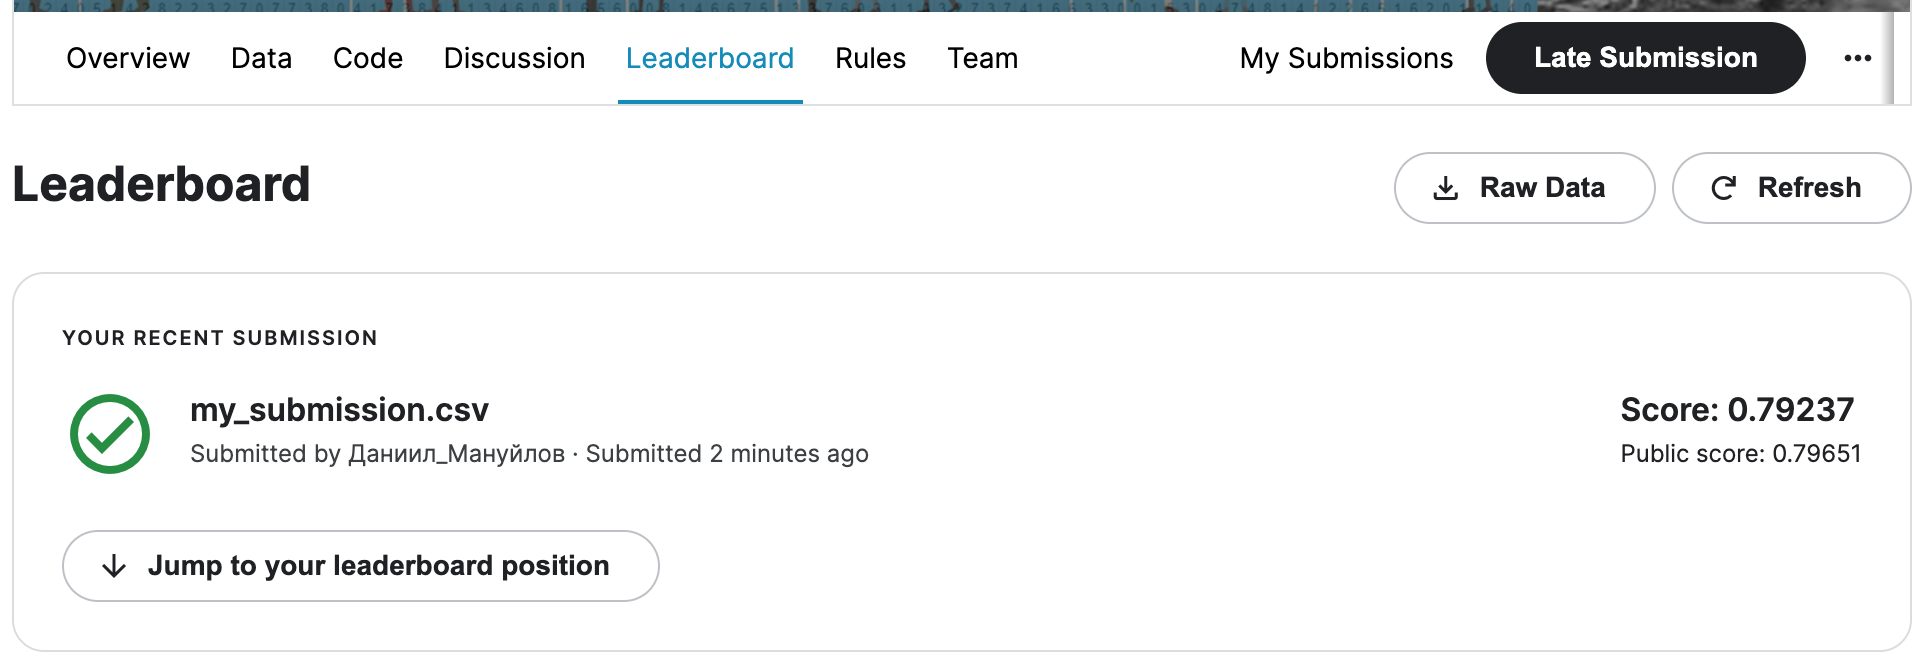

In [101]:
from IPython.display import Image
Image("pic.png")

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.